# Information Verifier System

This notebook implements an information verification system using:
- **LangGraph**: Workflow orchestration
- **LangChain**: LLM integration and tools
- **Hugging Face**: Classification models

## Requisites

- Python 3.11
- Pip package manager

## Packages Install

### With pip

In [1]:
%pip install -r requirements.txt -qU

Note: you may need to restart the kernel to use updated packages.


### With UV

In [2]:
%pip install uv

Note: you may need to restart the kernel to use updated packages.


In [3]:
!uv pip install -r requirements.txt

Audited 77 packages in 60ms


## Imports And Keys

In [4]:
import getpass
import os
# OpenAI Version
if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key: ")

Enter your OpenAI API key:  ········


In [5]:
import io
import re
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from typing import TypedDict, Literal, List
from pydantic import BaseModel
from langchain_core.documents import Document
from enum import Enum, auto
from PIL import Image
from langgraph.graph import StateGraph, START, END
from nba_qa_system import NBAQASystem


## Definitions

In [6]:
class ClassificationResult(Enum):
    REAL = auto()
    FAKE = auto()
    DOUBTFUL = auto()

class ClassificationOutput(BaseModel):
    """Structured output for claim classification"""
    classification: Literal["REAL", "FAKE", "DOUBTFUL"]
    explanation: str

class Source(BaseModel):
    url: str
    title: str
    snippet: str
    credibility_score: float = 0.5

class Evidence(BaseModel):
    claim: str
    supporting_text: str
    source: Source
    relevance_score: float

class VerificationState(TypedDict):
    user_input: str
    enhanced_query: str
    search_results: List[Document]
    evidence: List[Evidence]
    classification: ClassificationResult
    confidence: float
    explanation: str
    sources: List[Source]
    valid_query: str

## Models

In [7]:
model = ChatOpenAI(model="gpt-4o-mini", temperature=0)
# Initialize QA system with fine-tuned model
qa_system = NBAQASystem(model_name="utils/model_nba_qa_finetuned")

Device set to use mps:0


## Nodes

In [8]:
def validate_query_node(state: VerificationState) -> VerificationState:
    """Validate user query using NBA QA system's entity analyzer (hybrid approach)"""
    query = state['user_input']
    
    # Step 1: Use QA system's analyzer to extract NBA entities (fast, domain-specific)
    analysis = qa_system.analyzer.analyze(query)
    
    # Check if NBA-related entities were found
    has_players = len(analysis.entities.get('players', [])) > 0
    has_teams = len(analysis.entities.get('teams', [])) > 0
    has_stats = len(analysis.entities.get('stats', [])) > 0
    has_nba_keywords = any(keyword in query.lower() for keyword in [
        'nba', 'finals', 'playoffs', 'championship', 'basketball'
    ])
    
    # If any NBA entity found, it's NBA-related
    if has_players or has_teams or has_stats or has_nba_keywords:
        answer = "YES"
    else:
        # Step 2: Fallback to LLM for ambiguous cases
        # This handles cases like "basketball player" without specific names
        prompt = f"""Is this query about NBA (National Basketball Association) basketball? 
        Answer only YES or NO, nothing else.
        
        Query: {query}"""
        
        try:
            response = model.invoke([HumanMessage(content=prompt)])
            raw_answer = response.content.strip().upper()
            
            # Extract YES or NO from response (handles cases with extra text)
            if "YES" in raw_answer or raw_answer.startswith("Y"):
                answer = "YES"
            elif "NO" in raw_answer or raw_answer.startswith("N"):
                answer = "NO"
            else:
                # Default to NO if unclear
                answer = "NO"
        except Exception as e:
            # If LLM fails, default to NO
            print(f"Warning: LLM validation failed: {e}")
            answer = "NO"
    
    return {
        **state,
        "valid_query": answer
    }

In [9]:
def enhance_query_node(state: VerificationState) -> VerificationState:
    """Enhance user query for better search results"""
    prompt = f"""Given the following user query or claim, create an optimized search query 
    that will help verify the information. Extract key entities, dates, and facts.

    User input: {state['user_input']}
    
    Return only the enhanced search query, nothing else."""
    
    response = model.invoke([HumanMessage(content=prompt)])
    enhanced = response.content.strip()
    
    return {
        **state,
        "enhanced_query": enhanced
    }

In [10]:
def extract_evidence_node(state: VerificationState) -> VerificationState:
    """
    Extract evidence using fine-tuned NBA QA model
    """
    claim = state['user_input']
    enhanced_query = state['enhanced_query']

    try:
        # Use QA system to get evidence
        qa_result = qa_system.answer(enhanced_query or claim)

        # Create Evidence objects
        evidence_list = []
        if qa_result.answer and qa_result.confidence > 0:
            # Convert QA sources to Evidence format
            if qa_result.sources:
                for source in qa_result.sources:
                    evidence = Evidence(
                        claim=claim,
                        supporting_text=qa_result.context_used,
                        source=Source(
                            url=f"nba_api:{source.get('type', 'unknown')}",
                            title=f"NBA {source.get('type', 'data')}",
                            snippet=qa_result.answer,
                            credibility_score=qa_result.confidence
                        ),
                        relevance_score=qa_result.confidence
                    )
                    evidence_list.append(evidence)
            else:
                # If no sources but we have an answer, create a single evidence
                evidence = Evidence(
                    claim=claim,
                    supporting_text=qa_result.context_used,
                    source=Source(
                        url="nba_api:general",
                        title="NBA API Data",
                        snippet=qa_result.answer,
                        credibility_score=qa_result.confidence
                    ),
                    relevance_score=qa_result.confidence
                )
                evidence_list.append(evidence)

        return {
            **state,
            "evidence": evidence_list,
            "sources": [e.source for e in evidence_list],
            "search_results": [Document(page_content=qa_result.context_used)] if qa_result.context_used else []
        }
    except Exception as e:
        # Handle errors gracefully
        return {
            **state,
            "evidence": [],
            "sources": [],
            "search_results": [],
            "explanation": f"Error retrieving evidence from NBA API: {str(e)}"
        }

In [11]:
def classify_claim_node(state: VerificationState) -> VerificationState:
    """
    Classify the claim as REAL, FAKE, or DOUBTFUL based on evidence using structured output
    """
    
    # Create structured output model
    structured_llm = model.with_structured_output(ClassificationOutput)
    
    prompt = f"""Based on the following evidence, classify the claim as REAL, FAKE, or DOUBTFUL.
    
    Claim: {state['user_input']}
    
    Evidence:
    {chr(10).join([f"- {e.supporting_text} (Source: {e.source.title}, Credibility: {e.source.credibility_score})" for e in state['evidence']])}
    
    Provide your classification (REAL, FAKE, or DOUBTFUL) and a brief explanation."""
    
    # Get structured response
    response = structured_llm.invoke([HumanMessage(content=prompt)])
    
    # Map string classification to enum
    classification_map = {
        "REAL": ClassificationResult.REAL,
        "FAKE": ClassificationResult.FAKE,
        "DOUBTFUL": ClassificationResult.DOUBTFUL
    }
    classification = classification_map.get(response.classification, ClassificationResult.DOUBTFUL)
    
    # Estimate confidence based on evidence credibility
    if state['evidence']:
        avg_credibility = sum(e.source.credibility_score for e in state['evidence']) / len(state['evidence'])
        confidence = avg_credibility
    else:
        confidence = 0.0
    
    return {
        **state,
        "classification": classification,
        "confidence": confidence,
        "explanation": response.explanation
    }

In [12]:
def decline_node(state: VerificationState) -> VerificationState:
    """Decline queries that don't relate to NBA"""
    message = f"Your query does not relate to the NBA theme.\n\nYour input: '{state['user_input']}'\n\nPlease provide a query or claim related to NBA (National Basketball Association) for verification."
    state['explanation'] = message
    return state

## Conditional Nodes

In [13]:
def decide_over_input_node(state: VerificationState) -> Literal["enhance_query", "decline"]:
    if state["valid_query"] == "YES":
        return "enhance_query"
    else:
        return "decline"

## Workflow

In [14]:
builder = StateGraph(VerificationState)

builder.add_node("enhance_query", enhance_query_node)
builder.add_node("validate_query", validate_query_node)
builder.add_node("decline", decline_node)
builder.add_node("extract_evidence", extract_evidence_node)
builder.add_node("classify_claim", classify_claim_node)

builder.add_edge(START, "validate_query")
builder.add_conditional_edges("validate_query", decide_over_input_node)
builder.add_edge("decline", END)
builder.add_edge("enhance_query", "extract_evidence")
builder.add_edge("extract_evidence", "classify_claim")
builder.add_edge("classify_claim", END)
graph = builder.compile()

### Workflow Image

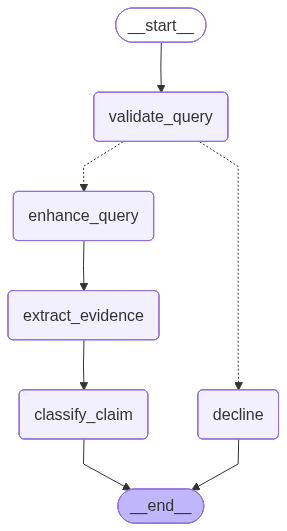

In [15]:
png_bytes = graph.get_graph(xray=True).draw_mermaid_png()
Image.open(io.BytesIO(png_bytes))

In [16]:
user_input = "Kobe Bryant scored 23 points in the 2010 NBA Finals Game 7"
#user_input = "LeBron James was a golf player?" # Should be declined
#user_input = "The capital of France is Paris." # Should be declined

In [17]:
# Example usage
config = {"configurable": {"thread_id": "1"}}

initial_state = VerificationState(
    user_input=user_input,
    enhanced_query="",
    search_results=[],
    evidence=[],
    classification=ClassificationResult.DOUBTFUL,
    confidence=0.0,
    explanation="",
    sources=[],
    valid_query=""
)

result = graph.invoke(initial_state, config)

In [18]:
# Display the results
print("=" * 60)
print("VERIFICATION RESULT")
print("=" * 60)
print(f"\nClaim: {result['user_input']}")
print(f"\nValid Query: {result['valid_query']}")
print(f"\nEnhanced Query: {result['enhanced_query']}")
print(f"\nExplanation: {result['explanation']}")
print(f"\nClassification: {result['classification'].name}")
print("\nEvidence Sources:")
for source in result['sources']:
    print(f"- {source.title} ({source.url}) - Credibility: {source.credibility_score:.2f}")

VERIFICATION RESULT

Claim: Kobe Bryant scored 23 points in the 2010 NBA Finals Game 7

Valid Query: YES

Enhanced Query: "Kobe Bryant 2010 NBA Finals Game 7 points scored stats"

Explanation: The provided evidence does not directly confirm or deny Kobe Bryant's score in the 2010 NBA Finals Game 7. It gives general statistics about his career and a specific season (1996-97), which is not relevant to the 2010 NBA Finals. The credibility score of the source is also very low, further adding to the doubt. Therefore, without specific information about the 2010 NBA Finals Game 7, the claim is classified as DOUBTFUL.

Classification: DOUBTFUL

Evidence Sources:
- NBA player_career_stats (nba_api:player_career_stats) - Credibility: 0.00
